This jupyter notebook loads a trajectory of a fully bound ligand and predicts the binding pose

The following files and options need to be customized for your system.

In [1]:
# Input files
# A pdb file for topology
complex_pdb = 'bound.pdb'
# The dcd is the trajectory of the bound complex
complex_dcd = 'bound.dcd'

# This dcd file keeps the predicted poses
poses_dcd = 'poses.dcd'

# A string to select ligand atoms
sel_str_ligand = 'resname LIG and not name H*'

In [2]:
# A class to perform RMSD calculations
import numpy as np
from munkres import Munkres
from MDAnalysis.analysis.base import AnalysisBase

class HungarianRMSD(AnalysisBase):
  """Hungarian symmetry-corrected root mean square deviation
  
  HungarianRMSD(atomgroup, ref_conf)
  
  Arguments
  ---------
  atomgroup : AtomGroup
    AtomGroup
  ref_conf : numpy.array (Nx3)
    refrence configuration or None to use AtomGroup configuration

  See http://dock.compbio.ucsf.edu/DOCK_6/dock6_manual.htm#LigandRMSD
  """
  def __init__(self, atomgroup, ref_conf=None, atom_types=None, **kwargs):
    """
    sel is an AtomGroup object MDAnalysis.core.groups
    ref_conf is the default reference configuration, an Nx3 numpy array
    atom_types is a list of strings
    """
    super(HungarianRMSD, self).__init__(atomgroup.universe.trajectory, **kwargs)
    
    self._ag = atomgroup
    if ref_conf is not None:
      self._ref_conf = ref_conf
    else:
      self._ref_conf = np.copy(self._ag.positions)
      
    if atom_types is not None:
      self._atom_types = atom_types
    else:
      self._atom_types = self._ag.types
        
    self.atom_sets_to_compare = []
    atom_indices = np.array(range(len(self._atom_types)))
    for t in set(self._atom_types):
      indices_t = (self._atom_types == t)
      self.atom_sets_to_compare.append((sum(indices_t), atom_indices[indices_t]))    
    
    self.munkres = Munkres()
    
  def set_ref_conf(self, ref_conf):
    """
    Sets a new reference configuration
    """
    self._ref_conf = ref_conf

  def _prepare(self):
    self.rmsds = []

  def _single_frame(self):
    ssd = 0.
    conf = self._ag.positions
    for (nelements, atom_set) in self.atom_sets_to_compare:
      if nelements == 1:
        j = atom_set[0]
        ssd += np.sum(np.square(conf[j, :] - self._ref_conf[j, :]))
      else:
        cost_matrix = np.array([[\
          np.sum(np.square(conf[atom_set[j],:]-self._ref_conf[atom_set[k],:])) \
            for j in range(nelements)] \
              for k in range(nelements)])
        path = self.munkres.compute(cost_matrix)
        ssd += np.sum([np.sum(np.square(\
          conf[atom_set[j],:]-self._ref_conf[atom_set[k],:])) for (j,k) in path])
    self.rmsds.append(np.sqrt(ssd / self._ag.n_atoms))

In [3]:
# Load the complex
import MDAnalysis as mda

complex = mda.Universe(complex_pdb, complex_dcd)
sel_ligand = complex.select_atoms(sel_str_ligand)

complex_pdb_reader = mda.coordinates.PDB.PDBReader(complex_pdb)
AMBER_atom_types = []
for line in complex_pdb_reader.remarks[1:-1]:
  AMBER_atom_types += line.split()
ligand_AMBER_atom_types = np.array(AMBER_atom_types)[sel_ligand.indices]

In [4]:
# Calculates the RMSD matrix
calcHungarianRMSD = HungarianRMSD(sel_ligand, atom_types = ligand_AMBER_atom_types)

import os, pickle

if not os.path.isfile('rmsds.pkl'):
  rmsds = []
  complex.trajectory.rewind()
  for frame in range(complex.trajectory.n_frames):
    calcHungarianRMSD.set_ref_conf(complex.trajectory[frame].positions[sel_ligand.indices,:])
    calcHungarianRMSD.start = frame + 1
    calcHungarianRMSD.run()
    print(f'Calculated {len(calcHungarianRMSD.rmsds)} rmsds relative to frame {frame}')
    rmsds += calcHungarianRMSD.rmsds
    complex.trajectory.next()
  F = open('rmsds.pkl','wb')
  pickle.dump(np.array(rmsds), F)
  F.close()
else:
  F = open('rmsds.pkl','rb')
  rmsds = pickle.load(F)
  F.close()

In [5]:
from scipy.spatial.distance import squareform
rmsds_sq = squareform(rmsds)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


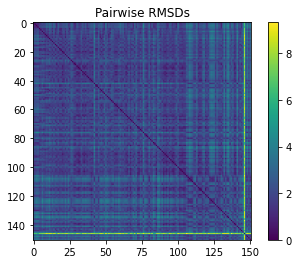

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(rmsds_sq)
plt.title('Pairwise RMSDs')
plt.colorbar()

In [7]:
import scipy.cluster
Z = scipy.cluster.hierarchy.linkage(rmsds, method='complete')
assignments = np.array(\
  scipy.cluster.hierarchy.fcluster(Z, 2, criterion='distance'))

# Reindexes the assignments in order of appearance
new_index = 0
mapping_to_new_index = {}
for assignment in assignments:
  if not assignment in mapping_to_new_index.keys():
    mapping_to_new_index[assignment] = new_index
    new_index += 1
assignments = [mapping_to_new_index[a] for a in assignments]

Text(0.5, 1.0, 'Cluster assignments')

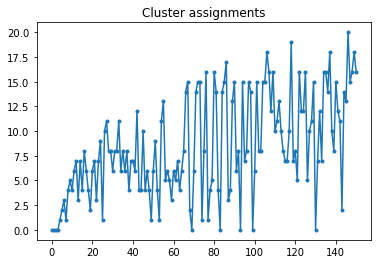

In [8]:
plt.plot(assignments,'.-')
plt.title('Cluster assignments')

In [9]:
# Create a list of how many frames are in a cluster and the representative frame from each cluster
counts_and_medoids = []
for n in range(max(assignments) + 1):
  inds = [i for i in range(len(assignments)) if assignments[i] == n]
  rmsds_n = rmsds_sq[inds][:, inds]
  counts_and_medoids.append((len(inds), inds[np.argmin(np.mean(rmsds_n, 0))]))
counts_and_medoids.sort(reverse=True)

In [10]:
# Writes the representative frames to a new dcd file in decreasing order of population
from MDAnalysis.coordinates.memory import MemoryReader
writer = mda.Writer(poses_dcd, complex.atoms.n_atoms)
complex_out = mda.Universe(complex_pdb)

for (count, medoid) in counts_and_medoids:
  if count==1:
    pass
  positions = complex.trajectory[medoid].positions
  complex_out.load_new(positions, format=MemoryReader)
  writer.write(complex_out)